In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.distributions import Normal
import random
import numpy as np


## 1.定义算法
### 1.1 建立Q网络和策略网络

In [75]:
class ValueNet(nn.Module):
    def __init__(self, n_states, hidden_dim, init_w=3e-3):
        super(ValueNet, self).__init__()
        '''定义值网络
        '''
        self.linear1 = nn.Linear(n_states, hidden_dim) # 输入层
        self.linear2 = nn.Linear(hidden_dim, hidden_dim) # 隐藏层
        self.linear3 = nn.Linear(hidden_dim, 1)

        self.linear3.weight.data.uniform_(-init_w, init_w) # 初始化权重
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
        
        
class SoftQNet(nn.Module):
    def __init__(self, n_states, n_actions, hidden_dim, init_w=3e-3):
        super(SoftQNet, self).__init__()
        '''定义Q网络，n_states, n_actions, hidden_dim, init_w分别为状态维度、动作维度隐藏层维度和初始化权重
        '''
        self.linear1 = nn.Linear(n_states + n_actions, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
        
        
class PolicyNet(nn.Module):
    def __init__(self, n_states, n_actions, hidden_dim, init_w=3e-3, log_std_min=-20, log_std_max=2):
        super(PolicyNet, self).__init__()
        '''定义策略网络，n_states, n_actions, hidden_dim, init_w分别为状态维度、动作维度隐藏层维度和初始化权重
        log_std_min和log_std_max为标准差对数的最大值和最小值
        '''
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.linear1 = nn.Linear(n_states, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        
        self.mean_linear = nn.Linear(hidden_dim, n_actions)
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)
        
        self.log_std_linear = nn.Linear(hidden_dim, n_actions)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        
        mean    = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        return mean, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        ## 计算动作
        normal = Normal(mean, std)
        z = normal.sample()
        action = torch.tanh(z)
        ## 计算动作概率
        log_prob = normal.log_prob(z) - torch.log(1 - action.pow(2) + epsilon)
        log_prob = log_prob.sum(-1, keepdim=True)
        
        return action, log_prob, z, mean, log_std
        
    
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(mean, std)
        z      = normal.sample()
        action = torch.tanh(z)
        
        action  = action.detach().cpu().numpy()
        return action[0]

### 1.2 定义经验回放池

In [76]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity # 经验回放的容量
        self.buffer = [] # 缓冲区
        self.position = 0 
    
    def push(self, state, action, reward, next_state, done):
        ''' 缓冲区是一个队列，容量超出时去掉开始存入的转移(transition)
        '''
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity 
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size) # 随机采出小批量转移
        state, action, reward, next_state, done =  zip(*batch) # 解压成状态，动作等
        return state, action, reward, next_state, done
    
    def __len__(self):
        ''' 返回当前存储的量
        '''
        return len(self.buffer)

### 1.3 SAC算法

In [77]:
class SAC:
    def __init__(self,cfg) -> None:
        self.n_states = cfg.n_states
        self.n_actions = cfg.n_actions
        self.batch_size  = cfg.batch_size 
        self.memory = ReplayBuffer(cfg.capacity)
        self.device = cfg.device
        self.action_space = cfg.action_space
        self.value_net  = ValueNet(self.n_states, cfg.hidden_dim).to(self.device)
        self.target_value_net = ValueNet(self.n_states, cfg.hidden_dim).to(self.device)
        self.soft_q_net = SoftQNet(self.n_states, self.n_actions, cfg.hidden_dim).to(self.device)
        self.policy_net = PolicyNet(self.n_states, self.n_actions, cfg.hidden_dim).to(self.device)  
        self.value_optimizer  = Adam(self.value_net.parameters(), lr=cfg.value_lr)
        self.soft_q_optimizer = Adam(self.soft_q_net.parameters(), lr=cfg.soft_q_lr)
        self.policy_optimizer = Adam(self.policy_net.parameters(), lr=cfg.policy_lr)  
        for target_param, param in zip(self.target_value_net.parameters(), self.value_net.parameters()):
            target_param.data.copy_(param.data)
        self.value_criterion  = nn.MSELoss()
        self.soft_q_criterion = nn.MSELoss()
    def update(self, gamma=0.99,mean_lambda=1e-3,
        std_lambda=1e-3,
        z_lambda=0.0,
        soft_tau=1e-2,
        ):
        if len(self.memory) < self.batch_size: # 当经验回放中不满足一个批量时，不更新策略
            return 
        state, action, reward, next_state, done = self.memory.sample(self.batch_size) # 从经验回放中随机采样一个批量的转移(transition)
        # 将数据转换为tensor
        state      = torch.FloatTensor(state).to(self.device)
        next_state = torch.FloatTensor(next_state).to(self.device)
        action     = torch.FloatTensor(action).to(self.device)
        reward     = torch.FloatTensor(reward).unsqueeze(1).to(self.device)
        done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(self.device)
        
        expected_q_value = self.soft_q_net(state, action) #计算t时刻的状态-动作Q值
        expected_value   = self.value_net(state) #计算t时刻的状态值
        new_action, log_prob, z, mean, log_std = self.policy_net.evaluate(state) #计算t时刻的动作、动作似然概率、正态分布抽样、分布均值和标准差


        target_value = self.target_value_net(next_state) #计算t+1时刻的状态值
        next_q_value = reward + (1 - done) * gamma * target_value # 时序差分计算t+1时刻的Q值
        # JQ = 𝔼(st,at)~D[0.5(Q1(st,at) - r(st,at) - γ(𝔼st+1~p[V(st+1)]))^2]
        q_value_loss = self.soft_q_criterion(expected_q_value, next_q_value.detach()) #计算q网路的损失函数

        expected_new_q_value = self.soft_q_net(state, new_action) #计算t时刻动作对应的q值
        next_value = expected_new_q_value - log_prob # 计算t时刻的v值
        value_loss = self.value_criterion(expected_value, next_value.detach()) #计算值网络损失函数
        
        ## 计算策略损失
        log_prob_target = expected_new_q_value - expected_value 
        # Jπ = 𝔼st∼D,εt∼N[α * logπ(f(εt;st)|st) − Q(st,f(εt;st))]
        policy_loss = (log_prob * (log_prob - log_prob_target).detach()).mean()

        ## 计算reparameterization参数损失
        mean_loss = mean_lambda * mean.pow(2).mean()
        std_loss  = std_lambda  * log_std.pow(2).mean()
        z_loss    = z_lambda    * z.pow(2).sum(1).mean()

        policy_loss += mean_loss + std_loss + z_loss

        self.soft_q_optimizer.zero_grad()
        q_value_loss.backward()
        self.soft_q_optimizer.step()

        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()

        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()
        ## 更新目标值网络参数
        for target_param, param in zip(self.target_value_net.parameters(), self.value_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )


## 2.模型训练与测试

In [78]:
def train(cfg, env, agent):
    print("开始训练！")
    rewards = [] # 记录所有回合的奖励
    for i_ep in range(cfg.train_eps):
        state = env.reset() # 重置环境，返回初始状态
        ep_reward = 0 # 记录一回合内的奖励
        for i_step in range(cfg.max_steps):
            action = agent.policy_net.get_action(state)  # 抽样动作
            next_state, reward, terminated, info = env.step(action)  # 更新环境，返回transitions
            agent.memory.push(state, action, reward,next_state, terminated)  # 保存transition
            agent.update()  # 更新智能体
            state = next_state  # 更新下一个状态
            ep_reward += reward  # 累加奖励
            if terminated:
                break
        if (i_ep+1)%10 == 0:
            print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.2f}")
        rewards.append(ep_reward)
    print("完成训练！")
    return {'rewards':rewards}
def test(cfg, env, agent):
    print("开始测试！")
    rewards = [] # 记录所有回合的奖励
    for i_ep in range(cfg.test_eps):
        state = env.reset() # 重置环境，返回初始状态
        ep_reward = 0
        for i_step in range(cfg.max_steps):
            action = agent.policy_net.get_action(state)  # 抽样动作
            next_state, reward, terminated, info = env.step(action)  # 更新环境，返回transitions
            state = next_state  # 更新下一个状态
            ep_reward += reward  # 累加奖励
            if terminated:
                break
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg.test_eps}，奖励：{ep_reward:.2f}")
    print("完成测试！")
    return {'rewards':rewards}

## 3.定义环境

In [79]:
import gym
import os
import numpy as np

class NormalizedActions(gym.ActionWrapper):
    def action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        
        return action

    def reverse_action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        action = 2 * (action - low) / (high - low) - 1
        action = np.clip(action, low, high)
        return action
    
def all_seed(env,seed = 1):
    ''' 万能的seed函数
    '''
    env.seed(seed) # env config
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
def env_agent_config(cfg):
    env = NormalizedActions(gym.make(cfg.env_name)) # 创建环境
    all_seed(env,seed=cfg.seed)
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.shape[0]
    print(f"状态空间维度：{n_states}，动作空间维度：{n_actions}")
    # 更新n_states和n_actions到cfg参数中
    setattr(cfg, 'n_states', n_states)
    setattr(cfg, 'n_actions', n_actions) 
    setattr(cfg, 'action_space', env.action_space) 
    agent = SAC(cfg)
    return env,agent

## 4.设置参数

In [84]:
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
class Config:
    def __init__(self):
        self.algo_name = 'SAC'
        self.env_name = 'Pendulum-v1'
        self.seed = 50 # 随机种子
        self.train_eps = 400 # 训练迭代次数
        self.test_eps = 10 # 测试迭代次数
        self.eval_eps = 10 # 评估迭代次数
        self.max_steps = 200 # 每次迭代最大时间步
        self.gamma = 0.99 #折扣因子
        self.mean_lambda=1e-3 # 重参数化分布均值的损失权重
        self.std_lambda=1e-3 # 重参数化分布标准差的损失权重
        self.z_lambda=0.0 # 重参数化分布抽样值的损失权重
        self.soft_tau=1e-2 # 目标网络软更新系数
        self.value_lr  = 3e-4 # 值网络的学习率
        self.soft_q_lr = 3e-4 # Q网络的学习率
        self.policy_lr = 3e-4 # 策略网络的学习率
        self.capacity = 1000000 # 经验缓存池的大小
        self.hidden_dim = 256 # 隐藏层维度
        self.batch_size  = 128 # 批次大小
        self.start_steps = 1000 # 利用前的探索步数
        self.buffer_size = 1000000 # 经验回放池大小
        self.device=torch.device("cpu") # 使用设备

def smooth(data, weight=0.9):  
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,title="learning curve"):
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{title}")
    plt.xlim(0, len(rewards), 10)  # 设置x轴的范围
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()


## 5.开始训练

状态空间维度：3，动作空间维度：1
开始训练！
回合：10/400，奖励：-1165.43
回合：20/400，奖励：-994.18
回合：30/400，奖励：-634.86
回合：40/400，奖励：-883.46
回合：50/400，奖励：-745.16
回合：60/400，奖励：-617.77
回合：70/400，奖励：-0.98
回合：80/400，奖励：-386.85
回合：90/400，奖励：-245.64
回合：100/400，奖励：-118.91
回合：110/400，奖励：-250.71
回合：120/400，奖励：-245.33
回合：130/400，奖励：-125.58
回合：140/400，奖励：-124.50
回合：150/400，奖励：-121.64
回合：160/400，奖励：-244.01
回合：170/400，奖励：-121.33
回合：180/400，奖励：-239.27
回合：190/400，奖励：-127.06
回合：200/400，奖励：-122.01
回合：210/400，奖励：-126.99
回合：220/400，奖励：-348.44
回合：230/400，奖励：-116.88
回合：240/400，奖励：-124.86
回合：250/400，奖励：-121.31
回合：260/400，奖励：-3.03
回合：270/400，奖励：-125.63
回合：280/400，奖励：-244.81
回合：290/400，奖励：-123.32
回合：300/400，奖励：-119.85
回合：310/400，奖励：-121.64
回合：320/400，奖励：-4.73
回合：330/400，奖励：-127.96
回合：340/400，奖励：-119.40
回合：350/400，奖励：-244.30
回合：360/400，奖励：-121.79
回合：370/400，奖励：-244.21
回合：380/400，奖励：-123.19
回合：390/400，奖励：-341.91
回合：400/400，奖励：-117.78
完成训练！
开始测试！
回合：1/10，奖励：-123.43
回合：2/10，奖励：-245.39
回合：3/10，奖励：-366.64
回合：4/10，奖励：-121.86
回合：5/10，奖励：-124.73
回合：

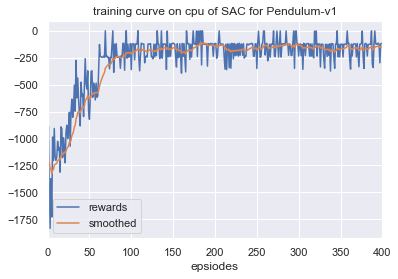

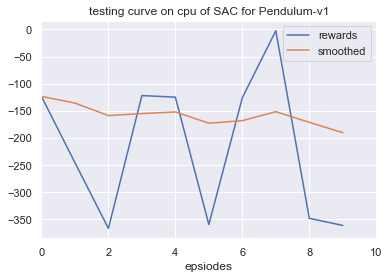

In [85]:
# 获取参数
cfg = Config() 
# 训练
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)
 
plot_rewards(res_dic['rewards'], title=f"training curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")  
# 测试
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], title=f"testing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")  # 画出结果